<a href="https://colab.research.google.com/github/tamara-kostova/MSc_Thesis_Neuroimaging/blob/master/sam3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SAM 3 exploration

## Install necessary dependencies

In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib scikit-learn
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam3.git'

PyTorch version: 2.9.0+cu126
Torchvision version: 0.24.0+cu126
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam3.git to /tmp/pip-req-build-50gpjrr1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam3.git /tmp/pip-req-build-50gpjrr1
  Resolved https://github.com/facebookresearch/sam3.git to commit 11dec2936de97f2857c1f76b66d982d5a001155d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for sam3: filename=sam3-0.1.0-py3-none-any.whl size=1865877 sha256=59c0d4fcafef23dc15c0790bcaecfa3db82e7d0872ba8fd2601c9d9540ae0cb1
  Stored in directory: /tmp/pip-ephem-wheel-cache-fzhayd7e/wheels/d0/2d/ba/135e3f5c76e53027dc9bfe15a474878249dcb047e3c0176d4e
Successfully built sam3
  Attempting uninstall: sam3
    Found existing installation: sam3 0.1.0
    Uninstalling sam3-0.1.0:
      Successfully uninstalled sam3-0.1.0


In [3]:
import torch
# turn on tfloat32 for Ampere GPUs
# https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# use bfloat16 for the entire notebook. If your card doesn't support it, try float16 instead
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()

# inference mode for the whole notebook. Disable if you need gradients
torch.inference_mode().__enter__()

/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


In [4]:
!pip install triton decord

In [5]:
!git clone https://github.com/facebookresearch/sam3.git
%cd sam3
!pip install -e ".[notebooks]"
%cd /content

!pip install -q supervision jupyter_bbox_widget

fatal: destination path 'sam3' already exists and is not an empty directory.
/content/sam3
Obtaining file:///content/sam3
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for sam3 (pyproject.toml) ... done
  Created wheel for sam3: filename=sam3-0.1.0-0.editable-py3-none-any.whl size=15368 sha256=4ab6f6a367a4b07833471676ffb152761a57fa001a47e6d24cac87c060846e1c
  Stored in directory: /tmp/pip-ephem-wheel-cache-lbprle2g/wheels/7c/90/be/80339bb9db8655024d6c9501da4e5efc6abbda4c897f5a6c43
Successfully built sam3
  Attempting uninstall: sam3
    Found existing installation: sam3 0.1.0
    Uninstalling sam3-0.1.0:
      Successfully uninstalled sam3-0.1.0
/content


In [6]:
import os
os.path.isfile("/content/sam3/sam3/assets/bpe_simple_vocab_16e6.txt.gz")

True

In [7]:
import sam3
from sam3.sam3 import build_sam3_image_model
import os
# sam3_root = os.path.join(os.path.dirname(sam3.__file__), "..")
bpe_path = f"/content/sam3/sam3/assets/bpe_simple_vocab_16e6.txt.gz"

In [8]:
from google.colab import userdata
import os
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

In [9]:
import sys
!{sys.executable} -m pip install --upgrade huggingface_hub

## Build model

In [10]:
model = build_sam3_image_model(bpe_path=bpe_path)

In [11]:
BASE_DIR = "/content/drive/MyDrive/MSc_Thesis_Neuroimaging"

## Try model with a test image

In [12]:
from PIL import Image
from sam3.model.sam3_image_processor import Sam3Processor
image_path = f"{BASE_DIR}/cat.jpg"
image = Image.open(image_path)
width, height = image.size
processor = Sam3Processor(model, confidence_threshold=0.5)
inference_state = processor.set_image(image)

found 1 object(s)


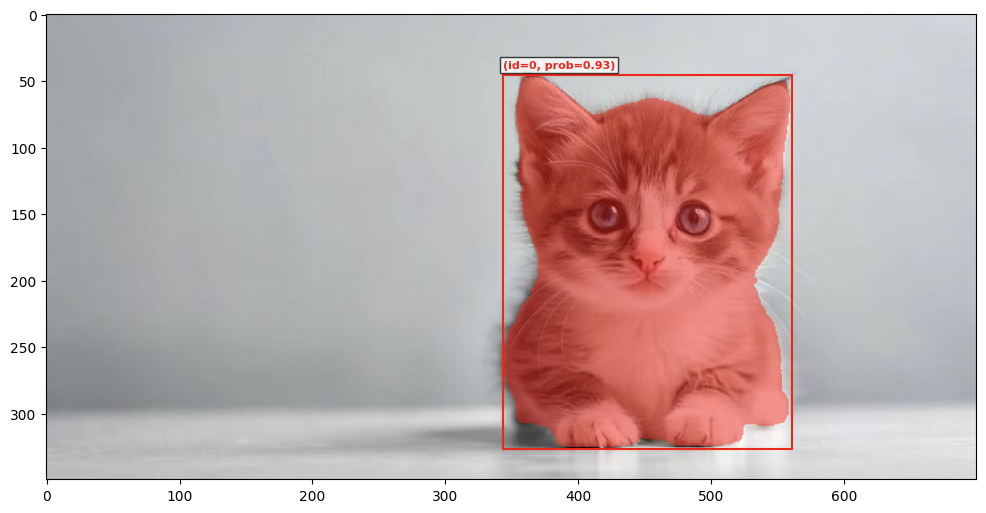

In [13]:
from sam3.visualization_utils import draw_box_on_image, normalize_bbox, plot_results
processor.reset_all_prompts(inference_state)
inference_state = processor.set_text_prompt(state=inference_state, prompt="cat")

img0 = Image.open(image_path)
plot_results(img0, inference_state)

## Test model with exampel images from MRI/CT datasets

### Imports

In [14]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import pandas as pd


In [22]:
BASEDIR = "/content/drive/MyDrive/MSc_Thesis_Neuroimaging/"
model = build_sam3_image_model(bpe_path=bpe_path)
confidence_threshold = 0.25
processor = Sam3Processor(model, confidence_threshold=confidence_threshold)

### Datasets

In [16]:
datasets = {
    "MRI_tumor_binary": {
        "path": f"{BASEDIR}/data/split/MRI_tumor_binary_norm/test",
        "modality": "MRI",
        "classes": ["normal", "tumor"]
    },
    "MRI_tumor_multiclass": {
        "path": f"{BASEDIR}/data/split/MRI_tumor_multiclass_norm/test",
        "modality": "MRI",
        "classes": ["normal", "*oma", "*toma"]
    },
    "MRI_ms": {
        "path": f"{BASEDIR}/data/split/MRI_ms_norm/test",
        "modality": "MRI",
        "classes": ["control", "MS"]
    },
    "CT_stroke": {
        "path": f"{BASEDIR}/data/split/CT_stroke_binary_norm/test",
        "modality": "CT",
        "classes": ["normal", "stroke"]
    }
}

In [17]:

def debug_paths(dataset_name, dataset_path):
    """Debug: show exact folder structure"""
    test_path = Path(dataset_path)

    print(f"\n🔍 DEBUGGING {dataset_name}:")
    print(f"   Base path exists? {test_path.exists()}")

    if test_path.exists():
        all_items = list(test_path.iterdir())
        print(f"   Contents: {len(all_items)} items")

        for item in all_items[:10]:
            print(f"     📁 {item.name} ({'DIR' if item.is_dir() else 'FILE'})")

            if item.is_dir():
                files_in_dir = list(item.glob("*.png")) + list(item.glob("*.jpg"))
                print(f"       → {len(files_in_dir)} images")

    print("-" * 60)

In [18]:
def auto_detect_bbox(image_array, class_name):
    """Enhanced bbox detection per class"""

    if len(image_array.shape) == 3:
        gray = np.mean(image_array, axis=2)
    else:
        gray = image_array.copy()

    gray_norm = (gray - gray.min()) / (gray.max() - gray.min() + 1e-8)

    if "tumor" in class_name.lower():
        # Tumors: bright regions
        threshold = 0.35
        bright_pixels = gray_norm > threshold
    elif "ms" in class_name.lower():
        # MS lesions: small bright spots
        threshold = 0.4
        bright_pixels = gray_norm > threshold
    elif "stroke" in class_name.lower():
        # Stroke: dark regions
        threshold = 0.25
        bright_pixels = gray_norm < threshold
    elif "normal" in class_name.lower():
        # Normal: no segmentation expected
        h, w = gray.shape
        return [w//4, h//4, 3*w//4, 3*h//4]  # Center fallback
    else:
        # Default
        threshold = 0.3
        bright_pixels = gray_norm > threshold

    if bright_pixels.sum() < 50:  # Too few pixels
        h, w = gray.shape
        return [w//4, h//4, 3*w//4, 3*h//4]

    coords = np.where(bright_pixels)
    y_min, y_max = coords[0].min(), coords[0].max()
    x_min, x_max = coords[1].min(), coords[1].max()

    padding = 25
    h, w = gray.shape

    bbox = [
        max(0, x_min - padding),
        max(0, y_min - padding),
        min(w, x_max + padding),
        min(h, y_max + padding)
    ]

    return bbox

In [34]:
def evaluate_sam3_dataset(dataset_name, dataset_info, max_images_per_class=3):
    test_path = Path(dataset_info["path"])

    debug_paths(dataset_name, test_path)

    class_folders = []
    for pattern in dataset_info.get("classes", ["*"]):
        found = test_path.glob(pattern)
        class_folders.extend([f for f in found if f.is_dir()])

    print(f"\nFound {len(class_folders)} class folders: {[f.name for f in class_folders]}")

    all_results = []

    for class_folder in class_folders:
        class_name = class_folder.name

        if "normal" in class_name.lower() or "control" in class_name.lower():
            print(f"  ⏭️  Skipping: {class_name}")
            continue

        image_files = list(class_folder.glob("*.png")) + list(class_folder.glob("*.jpg"))

        if len(image_files) == 0:
            print(f"  ⚠️  No images in {class_name}")
            continue

        print(f"  🖼️  Processing {class_name}: {len(image_files)} images")

        for img_path in tqdm(image_files[:max_images_per_class], desc=f"  {class_name}"):
            try:
                image = Image.open(img_path)
                if image.mode != 'RGB':
                    image = image.convert('RGB')

                image_array = np.array(image)
                bbox = auto_detect_bbox(image_array, class_name)

                inference_state = processor.set_image(image)
                prompt = "segment the tumor" if "tumor" in class_name.lower() else "segment the lesion"
                inference_state = processor.set_text_prompt(state=inference_state, prompt=prompt)

                output = processor.predict_masks(
                    state=inference_state,
                    confidence_threshold=confidence_threshold
                )

                masks, boxes, scores = output["masks"], output["boxes"], output["scores"]

                if len(masks) > 0:
                    best_idx = np.argmax(scores)
                    mask = masks[best_idx]
                    score = scores[best_idx]

                    all_results.append({
                        'dataset': dataset_name,
                        'class': class_name,
                        'image': img_path.name,
                        'bbox': bbox,
                        'n_objects': len(masks),
                        'best_score': float(score),
                        'mask_ratio': float(mask.mean()),
                        'success': True
                    })
                else:
                    all_results.append({
                        'dataset': dataset_name,
                        'class': class_name,
                        'image': img_path.name,
                        'bbox': bbox,
                        'n_objects': 0,
                        'best_score': 0.0,
                        'mask_ratio': 0.0,
                        'success': False
                    })

            except Exception as e:
                all_results.append({
                    'dataset': dataset_name,
                    'class': class_name,
                    'image': img_path.name,
                    'error': str(e),
                    'success': False
                })

    if len(all_results) == 0:
        results_df = pd.DataFrame([{
            'dataset': dataset_name,
            'note': 'No images or folders found',
            'success': False
        }])
    else:
        results_df = pd.DataFrame(all_results)

    print(f"\n  ✅ {dataset_name}: {len(results_df)} images processed")
    if 'success' in results_df.columns:
        success_rate = results_df['success'].mean()
        print(f"  📊 Success rate: {success_rate:.1%}")
    else:
        print("  📊 No success column")

    return results_df

In [35]:
print("🔍 DEBUGGING ALL PATHS FIRST...")
for dataset_name, info in datasets.items():
    debug_paths(dataset_name, info["path"])

print("\n🚀 RUNNING SAM3 EVALUATION...")
all_results = {}

for dataset_name, info in datasets.items():
    try:
        results_df = evaluate_sam3_dataset(dataset_name, info)
        all_results[dataset_name] = results_df
    except Exception as e:
        print(f"❌ Error in {dataset_name}: {e}")

🔍 DEBUGGING ALL PATHS FIRST...

🔍 DEBUGGING MRI_tumor_binary:
   Base path exists? True
   Contents: 2 items
     📁 normal (DIR)
       → 225 images
     📁 tumor (DIR)
       → 225 images
------------------------------------------------------------

🔍 DEBUGGING MRI_tumor_multiclass:
   Base path exists? True
   Contents: 12 items
     📁 Carcinoma (DIR)
       → 2 images
     📁 Germinoma (DIR)
       → 7 images
     📁 Glioma (DIR)
       → 48 images
     📁 Granuloma (DIR)
       → 2 images
     📁 Meduloblastoma (DIR)
       → 2 images
     📁 Meningioma (DIR)
       → 170 images
     📁 Neurocitoma (DIR)
       → 43 images
     📁 Normal (DIR)
       → 18 images
     📁 Other (DIR)
       → 7 images
     📁 Papiloma (DIR)
       → 20 images
------------------------------------------------------------

🔍 DEBUGGING MRI_ms:
   Base path exists? True
   Contents: 2 items
     📁 Control (DIR)
       → 187 images
     📁 MS (DIR)
       → 399 images
-------------------------------------------------

  tumor: 100%|██████████| 3/3 [00:09<00:00,  3.10s/it]



  ✅ MRI_tumor_binary: 3 images processed
  📊 Success rate: 0.0%

🔍 DEBUGGING MRI_tumor_multiclass:
   Base path exists? True
   Contents: 12 items
     📁 Carcinoma (DIR)
       → 2 images
     📁 Germinoma (DIR)
       → 7 images
     📁 Glioma (DIR)
       → 48 images
     📁 Granuloma (DIR)
       → 2 images
     📁 Meduloblastoma (DIR)
       → 2 images
     📁 Meningioma (DIR)
       → 170 images
     📁 Neurocitoma (DIR)
       → 43 images
     📁 Normal (DIR)
       → 18 images
     📁 Other (DIR)
       → 7 images
     📁 Papiloma (DIR)
       → 20 images
------------------------------------------------------------

Found 12 class folders: ['Carcinoma', 'Germinoma', 'Glioma', 'Granuloma', 'Meduloblastoma', 'Meningioma', 'Neurocitoma', 'Papiloma', 'Schwannoma', 'Ttuberculoma', 'Meduloblastoma', 'Neurocitoma']
  🖼️  Processing Carcinoma: 2 images


  Carcinoma: 100%|██████████| 2/2 [00:06<00:00,  3.07s/it]


  🖼️  Processing Germinoma: 7 images


  Germinoma: 100%|██████████| 3/3 [00:09<00:00,  3.06s/it]


  🖼️  Processing Glioma: 48 images


  Glioma: 100%|██████████| 3/3 [00:09<00:00,  3.04s/it]


  🖼️  Processing Granuloma: 2 images


  Granuloma: 100%|██████████| 2/2 [00:06<00:00,  3.04s/it]


  🖼️  Processing Meduloblastoma: 2 images


  Meduloblastoma: 100%|██████████| 2/2 [00:06<00:00,  3.04s/it]


  🖼️  Processing Meningioma: 170 images


  Meningioma: 100%|██████████| 3/3 [00:09<00:00,  3.03s/it]


  🖼️  Processing Neurocitoma: 43 images


  Neurocitoma: 100%|██████████| 3/3 [00:09<00:00,  3.03s/it]


  🖼️  Processing Papiloma: 20 images


  Papiloma: 100%|██████████| 3/3 [00:09<00:00,  3.04s/it]


  🖼️  Processing Schwannoma: 24 images


  Schwannoma: 100%|██████████| 3/3 [00:09<00:00,  3.04s/it]


  🖼️  Processing Ttuberculoma: 1 images


  Ttuberculoma: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it]


  🖼️  Processing Meduloblastoma: 2 images


  Meduloblastoma: 100%|██████████| 2/2 [00:06<00:00,  3.05s/it]


  🖼️  Processing Neurocitoma: 43 images


  Neurocitoma: 100%|██████████| 3/3 [00:09<00:00,  3.05s/it]



  ✅ MRI_tumor_multiclass: 30 images processed
  📊 Success rate: 0.0%

🔍 DEBUGGING MRI_ms:
   Base path exists? True
   Contents: 2 items
     📁 Control (DIR)
       → 187 images
     📁 MS (DIR)
       → 399 images
------------------------------------------------------------

Found 1 class folders: ['MS']
  🖼️  Processing MS: 399 images


  MS: 100%|██████████| 3/3 [00:09<00:00,  3.05s/it]



  ✅ MRI_ms: 3 images processed
  📊 Success rate: 0.0%

🔍 DEBUGGING CT_stroke:
   Base path exists? True
   Contents: 2 items
     📁 normal (DIR)
       → 665 images
     📁 stroke (DIR)
       → 334 images
------------------------------------------------------------

Found 2 class folders: ['normal', 'stroke']
  ⏭️  Skipping: normal
  🖼️  Processing stroke: 334 images


  stroke: 100%|██████████| 3/3 [00:09<00:00,  3.05s/it]


  ✅ CT_stroke: 3 images processed
  📊 Success rate: 0.0%


In [36]:
summary_data = []
total_images = 0
total_success = 0

for dataset_name, results_df in all_results.items():
    if len(results_df) > 0 and 'success' in results_df.columns:
        n_images = len(results_df)
        n_success = results_df['success'].sum()
        success_rate = n_success / n_images

        summary_data.append({
            'Dataset': dataset_name,
            'Images': n_images,
            'Success': f"{success_rate:.1%}",
            'Avg Conf': f"{results_df[results_df['success']]['best_score'].mean():.3f}" if n_success > 0 else "N/A"
        })

        total_images += n_images
        total_success += n_success

if summary_data:
    summary_df = pd.DataFrame(summary_data)
    print(f"\n{'='*80}")
    print("🎯 SAM3 RESULTS SUMMARY")
    print(f"{'='*80}")
    print(summary_df.to_string(index=False))
else:
    print("\n❌ No results - check paths above!")


🎯 SAM3 RESULTS SUMMARY
             Dataset  Images Success Avg Conf
    MRI_tumor_binary       3    0.0%      N/A
MRI_tumor_multiclass      30    0.0%      N/A
              MRI_ms       3    0.0%      N/A
           CT_stroke       3    0.0%      N/A


In [ ]:
import torch
import gc

torch.cuda.empty_cache()
gc.collect()

print("GPU memory cleared!")
print(f"Free GPU memory: {torch.cuda.memory_reserved()/1e9:.1f}GB")

In [24]:
from pathlib import Path
import matplotlib.pyplot as plt

BASEDIR = "/content/drive/MyDrive/MSc_Thesis_Neuroimaging/"

tumor_base = Path(f"{BASEDIR}/data/split/MRI_tumor_binary_norm/test")

subfolders = [f for f in tumor_base.iterdir() if f.is_dir()]
print(f"Subfolders: {[f.name for f in subfolders]}")

for folder in subfolders:
    images = list(folder.glob("*.png")) + list(folder.glob("*.jpg"))
    print(f"  {folder.name}: {len(images)} images")
    if len(images) > 0:
        first_img = images[0]
        print(f"    First image: {first_img}")

tumor_images = []
for folder in subfolders:
    if 'tumor' in folder.name.lower() or 'ms' in folder.name.lower() or 'stroke' in folder.name.lower():
        images = list(folder.glob("*.png")) + list(folder.glob("*.jpg"))
        tumor_images.extend(images[:3])  # 3 per folder

print(f"\n🧠 Found {len(tumor_images)} pathology images for testing")

if len(tumor_images) == 0:
    print("❌ No pathology images found. List all images:")
    all_images = list(tumor_base.rglob("*.png")) + list(tumor_base.rglob("*.jpg"))
    print(f"All images: {len(all_images)}")
    if len(all_images) > 0:
        tumor_images = all_images[:5]
        print("Using first 5 images...")

if len(tumor_images) > 0:
    test_image_path = tumor_images[0]
    print(f"\n🧪 TESTING SAM3 ON: {test_image_path}")

    image = Image.open(test_image_path).convert('RGB')
    print(f"Image size: {image.size}, Mode: {image.mode}")

    try:
        inference_state = processor.set_image(image)
        output = processor.set_text_prompt(
            state=inference_state,
            prompt="segment the tumor"
        )

        masks, boxes, scores = output["masks"], output["boxes"], output["scores"]

        print(f"✅ SAM3 RESULTS:")
        print(f"  Masks found: {len(masks)}")
        print(f"  Scores: {[f'{s:.3f}' for s in scores]}")

        if len(masks) > 0:
            best_mask = masks[0]
            print(f"  Best mask ratio: {best_mask.mean():.1%}")

            # Visualize
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(image)
            plt.title("Original Image")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(image)
            plt.imshow(best_mask, alpha=0.6, cmap='Reds')
            plt.title(f"SAM3 Segmentation\nScore: {scores[0]:.3f}\nMask: {best_mask.mean():.1%}")
            plt.axis('off')

            plt.tight_layout()
            plt.savefig("sam3_tumor_test.png", dpi=150)
            plt.show()
        else:
            print("❌ No masks found - try lower confidence threshold")

    except Exception as e:
        print(f"❌ SAM3 Error: {e}")
        print("Full traceback:")
        import traceback
        traceback.print_exc()
else:
    print("❌ No images found anywhere!")


Subfolders: ['normal', 'tumor']
  normal: 225 images
    First image: /content/drive/MyDrive/MSc_Thesis_Neuroimaging/data/split/MRI_tumor_binary_norm/test/normal/no431.jpg
  tumor: 225 images
    First image: /content/drive/MyDrive/MSc_Thesis_Neuroimaging/data/split/MRI_tumor_binary_norm/test/tumor/y431.jpg

🧠 Found 3 pathology images for testing

🧪 TESTING SAM3 ON: /content/drive/MyDrive/MSc_Thesis_Neuroimaging/data/split/MRI_tumor_binary_norm/test/tumor/y431.jpg
Image size: (224, 224), Mode: RGB
✅ SAM3 RESULTS:
  Masks found: 0
  Scores: []
❌ No masks found - try lower confidence threshold
